First, prepare parameters and load the tx data

/mnt/class_data/esnyder/raw_data/ooi_optasense_north_c2_full/20211102_223131.h5


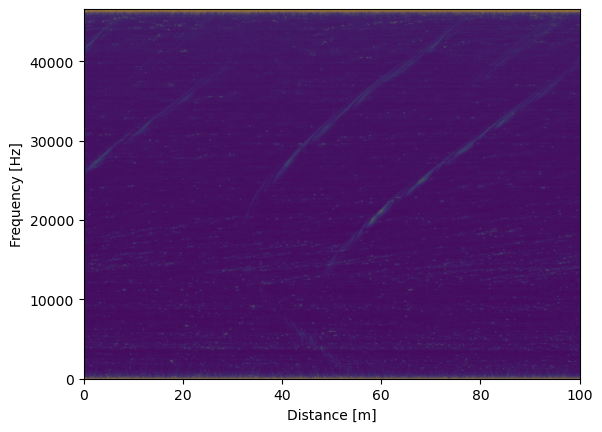

In [ ]:
# Verify labels work using matplotlib
import data_io as io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sp
import os
from IPython.display import display

label_file = r'/home/Eric/Documents/gitRepos/cv4e_dataPrep/fx_labels_Bp.csv'
tx_label_file = r'/home/Eric/Documents/gitRepos/cv4e_dataPrep/tx_labels_Bp.csv'
data_path = r'/mnt/class_data/esnyder/raw_data'
labels = pd.read_csv(label_file)

# Pick a random label row
row = labels.iloc[np.random.randint(0, len(labels))]
data_filepath = os.path.join(data_path, row['dataset'], row['source_file'])
print(data_filepath)

# Find all labels in same dataset & time
same_labels = labels[
    (labels['source_file'] == row['source_file']) &
    (labels['t'] == row['t'])
]

# load settings and data
settings_file = io.find_settings_h5(data_filepath)
settings = io.load_settings_preprocessed_h5(settings_file)
nonzeros = settings['rehydration_info']['nonzeros_mask']
original_shape = settings['rehydration_info']['target_shape']
dx = settings['processing_settings']['dx']
fs = settings['processing_settings']['fs']
fk_dehyd, timestamp = io.load_preprocessed_h5(data_filepath)

# Rehydrate
tx = 1e9 * io.rehydrate(fk_dehyd, nonzeros, original_shape, return_format='tx')

# define axes extents:
x_extent = tx.shape[0]*dx
f_extent = fs/2

# load tx labels:
tx_labels = pd.read_csv(tx_label_file)

# find labels that correspond to this data slice
tx_same_labels = tx_labels[
    (tx_labels['source_file'] == row['source_file'])
]

fig = plt.figure()
# extent = [x_min, x_max, y_min, y_max] for imshow
extent = [0, f_extent, 0, x_extent]
plt.imshow(tx, aspect='auto', extent=extent, origin='lower', vmin = 0, vmax=.4)
plt.xlabel('Distance [m]')
plt.ylabel('Frequency [Hz]')
plt.show()

Next, plot fx plot

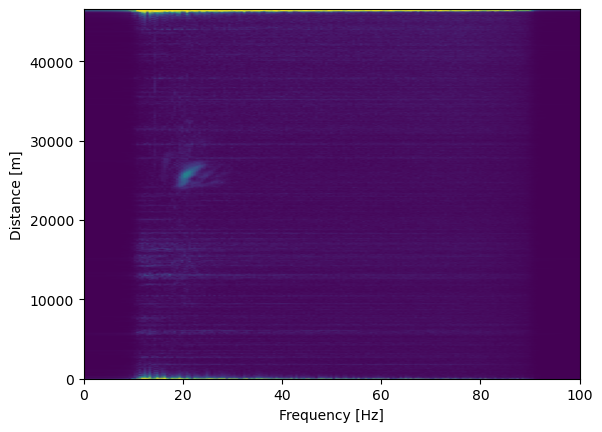

In [43]:
idx_start = int(row['t']*fs)
idx_end = int((row['t'] + 2)*fs-1)

tx_seg = tx[:, idx_start:idx_end]
fx_fullCable = np.abs(np.fft.rfft(tx_seg, axis=1))
# Plot full cable FX image
fig = plt.figure()
plt.imshow(fx_fullCable, aspect='auto', origin='lower', vmin=0, vmax=30,
           extent=[0, fs/2, 0, x_extent])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Distance [m]')
plt.show()



id                                                  736
tx_id                                                90
uid                91c5f715-9875-45fc-9c45-3a7ff19b5994
f_min_hz                                      14.892417
f_max_hz                                      24.993574
x_min_m                                    17912.745483
x_max_m                                    23463.254517
t                                                   0.0
win_length_s                                        2.0
dataset                     ooi_optasense_north_c2_full
label                                                 1
label_name                                         Bp_B
saved_timestamp                 2025-12-19 19:28:37.318
username                                         ers334
source_file                          20211102_215901.h5
Name: 690, dtype: object


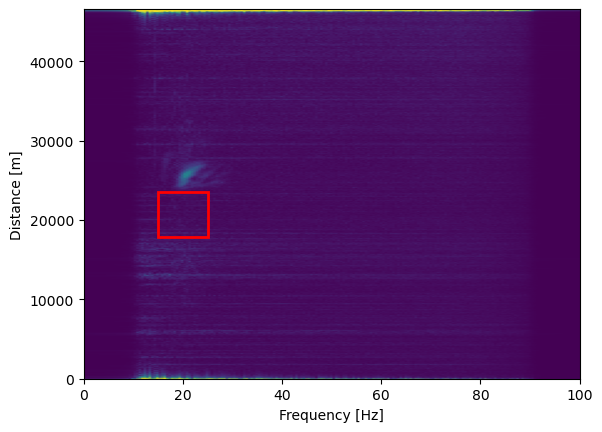

In [ ]:
# add the labels
print(row)

fig = plt.figure()
plt.imshow(fx_fullCable, aspect='auto', origin='lower', vmin=0, vmax=30,
           extent=[0, fs/2, 0, x_extent])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Distance [m]')
rect = plt.Rectangle(
    (row['f_min_hz'], row['x_min_m']),
    row['f_max_hz'] - row['f_min_hz'],
    row['x_max_m'] - row['x_min_m'],
    linewidth=2, edgecolor='r', facecolor='none'
    )
plt.gca().add_patch(rect)

for _, lab in same_labels.iterrows():
    rect = plt.Rectangle(
        (lab['f_min_hz'], lab['x_min_m']),
        lab['f_max_hz'] - lab['f_min_hz'],
        lab['x_max_m'] - lab['x_min_m'],
        linewidth=1, edgecolor='r', facecolor='none'
        )
    plt.gca().add_patch(rect)

plt.show()